
# TuIT_DeepRL - DRL Project
![OST](./resources/ost_logo.png)
## MiniF1RL: My pygame 2d racing environment for DRL
Author: Lars Herrmann    
Date: 12.04.2024  
Repository: [Github - miniF1RL](https://github.com/lherrman/miniF1RL)   
Python Version: 3.11

## Introduction
After a lot of experimentaition and consideration of what environment to use. (Playing with e.g. TrackManiaRL, Gymnasium Integrated Environemnts and Unity Environments), i decided to implement my own 2d racing environment. The main reason for this is that i wanted a environment where no pre-trained models are available what motivates me to train my own models. As i started watching formula one this season, i wanted to go with a racing environment. 

## Implementing the environment

### The CarModel
As a starting point, i was able to use a Python class of a simple 2d topdown car model that i implemented for another project about a year ago. The class already had methods to draw a simple 2d box car and it's wheels onto a pygame screen. As it wasn't intended as a racing game, and rather a geometrical model to controll an rc car, i had to implement an updated method for updating the cars position and velocity to make it more fun to drive. The original CarModel class can be found in my github repository for the [SlamCar Project](https://github.com/lherrman/slamcar-controller) in the file `base_model.py`. 

To make this into a racing environment, there were still some parts missing i startet to implement, starting with a track to drive on.

As of now, not a lot of the original code is left.

### The Track
In order to have a track to drive on, i decided to draw a black and white image of a track in Photoshop. When initializing the car model, i wrote a python method that uses the 'cv2.findContours' method to find the track boundaries in the image. The track is then represented as two lists of points, one for the inner and one for the outer boundary.

![Track Image](./resources/MakeTrack.png)


Python Code:
```python
    def _get_track_boundaries_from_image(self, image_path) -> dict:
        '''
        Using opencv to read the image and find the contours of the track boundaries.
        The boundaries are represented as list of points. ([x1, y1], [x2, y2], ...)
        '''
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(image.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        assert len(contours) == 2, "There should be exactly 2 contours in the image"

        # Transform and downsample the contours
        downsample_rate = 10
        inner_boundary = contours[0][:, 0, :][::downsample_rate]
        outer_boundary = contours[1][:, 0, :][::downsample_rate]

        # # Append last point to close the loop
        inner_boundary = np.append(inner_boundary, [inner_boundary[0]], axis=0)
        outer_boundary = np.append(outer_boundary, [outer_boundary[0]], axis=0)

        # Scale the contours to make suitable for the simulation
        inner_boundary, outer_boundary = inner_boundary / 60, outer_boundary / 60

        return {
            'inner': inner_boundary,
            'outer': outer_boundary
        }   
```

#### Track progress
To approximate the progress the car has made on the track, i implemented a method `_calculate_track_progress` that calculates the distance to the next point on the inner boundary. The first point on the inner boundary is set as the starting point. The progress is then calculated as the index of the nearest point divided by the total number of points on the inner boundary. This could be improved by taking the length of the segments passed into account.

### The observation space

I wanted to keep the observation space simple, so i decided to use 'lidar sensors', that give the car only a few distance measurements in front of it as its observations of the state. I decided to use 3 sensors, one in the middle and one on each side of the car in a 45 degree angle. The sensors are implemented as a method of the CarModel class that returns the distances to the track boundaries. 

The implementation of the `_segment_intersection` and `_raycast` methods was prompted to ChatGPT, which returned an working implementation after 2-3 iterations. The method uses an all python implementation for which the performance isn't optimal, but i guess it's good enough for my purposes. As the raycast method has to itterate over each segment of the boundaries, a more performant implementation would be very beneficial.


For easier validation, and because it looks cool, i decided to draw the lidar sensors as lines on the pygame screen.


![Lidar Sensors](./resources/lidars.png)

In addition to the 3 lidar sensors, i also added the cars steering angle to the observation space.


#### Update (16.05.2024):  
I implemented a more performant version of the raycast method using numpy and numba again with the help of a chatbot.

This sped up the maximum number of ticks per second from  about 230-300 to about 1000.

Measurements 

New Method:  
```
FPS: 59.53  | Ticks: 1001.00 | Tick Time: 0:00:00.999000 ms
```
Old Method:  
```
FPS: 52.12  | Ticks: 247.83 | Tick Time: 0:00:04.035000 ms
```


### The action space

The action space is also very simple. To make the problem even easier for the RL algorithm, i decided to always have the car accelerate, as slowing down isn't necessary in this environment. The car can steer left or right, or go straight. To make it a little more interesting, i added a third action, boost, that allows the car to go faster on the straights.

### The reward function

I decided the use the following 4 types of rewards:
- Progress reward: The car gets a reward for making progress on the track
- Speed reward: The car gets a reward for driving fast
- Finish reward: The car gets a reward for finishing the track
- Collision reward: The car gets a negative reward for colliding with the track boundaries

As the rewards are calculated from differently scaled values, the weigths of progress and speed can't be compared directly. After some testing, i decided to use the following weights for the rewards:
- Progress: 1000 (* fracton of the progress made in the last step)
- Speed: 1 (* speed in m/s)
- Finish: 100 (* 1 if the car has finished the track)
- Collision: -100 (* 1 if the car has collided with the track boundaries)

### Adding Graphics
To enhance the graphics of the environment, i generated a background image based on the drawn track by locally running a stable diffusion model and prompting it with the track image and a text description of the track i want.

I used the JuggernautXL model trough the [Fooocus UI](https://github.com/lllyasviel/Fooocus).  
I got the best results by setting the image prompt mode to CPDS, in order to keep the structure of the track. By decreasing the weight of the image prompt, the track structure is kept, but the model is free to generate a more interesting background.

![Image Gen](./resources/fooocus_image_gen.png)

Also for the car i generated a sprite image that is used to draw the car on the screen.   
Note: I also got some quite funny results:  
![Car Gen](./resources/car_fail.png)

The environment allows to switch between the simple wireframe graphics and the enhanced graphics by pressing the 'g' key.
I also added the possibility to zoom in and out using the mouse wheel. When the whole track is visible the camera will center on the track instead of the car.

## Demo animation
![Demo Animation](./resources/Trained_Env_Demo.gif)

## Helper functions

In [2]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import threading
import torch
import pygame as pg 
from minif1env import MiniF1RLEnv
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env
from torch.utils.tensorboard import SummaryWriter
from stable_baselines3.common.callbacks import CheckpointCallback
import os
import glob

def get_writer(texts: dict):
    writer = SummaryWriter()
    for key, value in texts.items():
        writer.add_text(str(key), str(value))
    return writer

# Use a separate thread to render the environment
# Avoids crashing the pg window during training
def render_loop(env: MiniF1RLEnv, 
           close_event, 
           human_control=False, 
           fps=60):
    pg.init()
    while True:
        delay_ms = 1000 // fps
        env.render()
        pg.time.wait(delay_ms) 

        done = env.handle_pg_events(human_control=human_control)

        if done:
           close_event.set()

        if close_event.is_set():
            pg.quit()
            return
        
def latest_checkpoint_file_path(model_description: str):
  checkpoint_dir = "checkpoints"
  checkpoint_files =  glob.glob(os.path.join(checkpoint_dir, f"*{model_description}*/*.zip"))
  if not checkpoint_files:
    return None
  latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
  return latest_checkpoint


pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Manual Play with the environment


In [4]:
env = MiniF1RLEnv()

done = False
last_frame = datetime.now()
while not done:

    # Limit framerate for manual controlls
    if (datetime.now() - last_frame).total_seconds() < 1/100:
        continue
    last_frame = datetime.now()

    exit = env.handle_pg_events(human_control=True)

    observation, step_reward, terminate, truncate, info = env.step(None)
    env.render()

    if terminate:
        env.reset()

    if exit:
        break

env.close()


# Training

In [ ]:


# Create the environment
env = MiniF1RLEnv()

# Create and start the rendering thread
close_event = threading.Event()
render_thread = threading.Thread(target=render_loop, args=(env,close_event,False,30))
render_thread.start()

# Set the training parameters
total_timesteps = 1_000_000
agent_description = "PPO"
policy_decription = "MlpPolicy"
model_description = f"{agent_description}_{policy_decription}_128_64_A5"
print(f"Training model: {model_description}")

# Define the policy network and check if GPU is available
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[128, 64])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

load_checkpoint = True
# Load the latest checkpoint if available, otherwise create a new model
latest_checkpoint = latest_checkpoint_file_path(model_description)
if load_checkpoint and latest_checkpoint:
  print(f"Loading checkpoint: {latest_checkpoint}")
  model = PPO.load(latest_checkpoint, env, verbose=1)
else:
  model = PPO(policy_decription, env, verbose=1, tensorboard_log=f"./logs", policy_kwargs=policy_kwargs, device=device)
run_name = datetime.now().strftime("%Y%m%d_%H%M%S") + "_" + model_description

# Save a checkpoint every 10000 steps
tb_logs = f"./logs/{run_name}"
checkpoint_callback = CheckpointCallback(
  save_freq=10_000,
  save_path=f"./checkpoints/{run_name}",
  name_prefix=f"{run_name}_checkpoint",
  save_replay_buffer=False,
  save_vecnormalize=True,
)

# Train the model
model.learn(total_timesteps=total_timesteps, 
            tb_log_name=run_name, 
            callback=checkpoint_callback)
model.save(f"models/{run_name}")

# Close the rendering thread and environment
close_event.set()
render_thread.join()
env.close()

# Close the tensorboard writer
#writer.close()

# Inference


In [10]:

model_description = "PPO_MlpPolicy_64_64_A3"
env = MiniF1RLEnv()

# Load the latest checkpoint that matches the model description
latest_checkpoint = latest_checkpoint_file_path(model_description)
if not latest_checkpoint:
    raise ValueError(f"No checkpoint found for model description: {model_description}")
print(f"Loading checkpoint: {latest_checkpoint}")

model = PPO.load(latest_checkpoint)

# Create and start the rendering thread
close_event = threading.Event()
render_thread = threading.Thread(target=render_loop, args=(env,close_event,False,30))
render_thread.start()

# Run the model
exit = False
while not exit:
    obs, info = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncate, info = env.step(action)
    
        if close_event.is_set():
            exit = True
            break

# Close the rendering thread and environment
close_event.set()
render_thread.join()
env.close()



Loading checkpoint: checkpoints\20240603_121512_PPO_MlpPolicy_64_64_A3\20240603_121512_PPO_MlpPolicy_64_64_A3_checkpoint_1000000_steps.zip


# Training Log
These are rougly the different stages at which i run the training.


## Tests 01
**Best Model:**  "a2c_minif1rl"   
**Timesteps**: 10'000   
**Total Training Time:**  ~1h  
**Algorithm:** A2C  
**Conditions:** After every crash, the car is reset to the starting position.
**Result:** The car learned to always directly drive into the right border.     
Explaination. After checking the rewards that were given to the model, i realized that the reward function was not working as intended. The weight for the progress reward was way to low so the model did not learn to follow the track. Probebly also the punishment for hitting the track boundaries was to low.

## Tests 02
**Best Model:**  "a2c_MlpPolicy_64_64_R4"   
**Timesteps**: 10'000  
**Total Training Time:**  ~1h   
**Algorithm:** PPO  
**Conditions:** After every crash, the car is reset to the starting position. I added some slight randomness to the starting position and heading of the car.   
**Result:** Still in most of the runs the car learned to drive into the right border. He never came to the point to get to the first left turn.

## Tests 03
Because the car was always driving into the right border, i decided to implement a new reset function. After every crash, the car is reset to a random position in the center of the track heading into track direction. When i saw that potentialy with the new reset function the car could learn to drive on the track, i tried different RL algorithms implemented in the [stable-baselines3](
https://github.com/DLR-RM/stable-baselines3) python library. I tried the following algorithms: A2C, PPO, DQN and SAC. Each of them i run for abour 20-40 minutes and i just monitored the progress of learning while the model was training. I found that the PPO algorithm was the most promising.

## Tests 04
**Best Model:**  "PPO_MlpPolicy_64_64_R7"   
**Timesteps**: 10'000  
**Total Training Time:**  ~1h  
**Algorithm:** PPO  
**Conditions:** (New reset function implemented) After every crash, the car is reset to a random position in the center of the track heading into track direction.    
**Result:** The car learned to drive on the track. On the best run, after about 10 minutes it learned to do the right curves pretty consistently. The left curves were still a problem until about 30 minutes into the training. I experience quite a large difference in learning speed between the different runs. Some runs never learned to drive on the track properly as the started to consistenlty drive into the right border.

# Training Runs V2
As is updated the environment wiht new configurations, i descided to restart my training process. I added better logging to TensorBoard to better track the progress.

This time, every run in a full run of 1'000'000 timesteps logged to TensorBoard.

## PPO_MlpPolicy_64_64_A2
Timesteps: 1'000'000    
Total Training Time:  ~110min   
Algorithm: PPO    
Policy: MlpPolicy with 64 hidden units and 64 output units

Reward Multipliers:
- Progress: 1000
- Speed: 1
- Finish: 100
- Collision: -200

Reward discount factor: 0.999  


## PPO_MlpPolicy_64_64_A3
Timesteps: 1'000'000    
Total Training Time:  ~110min   
Algorithm: PPO   
Policy: MlpPolicy with 64 hidden units and 64 output units

Reward Multipliers:
- Progress: 1000
- Speed: 1
- Finish: 100
- Collision: -200

Reward discount factor: **0.99**  

## PPO_MlpPolicy_64_64_A4
Timesteps: 1'000'000    
Total Training Time:  ~110min   
Algorithm: PPO   
Policy: MlpPolicy with 64 hidden units and 64 output units   

Reward Multipliers:
- Progress: 1000
- Speed: **10**
- Finish: 100
- Collision: -200

Reward discount factor: 0.99  


## PPO_MlpPolicy_128_64_A5
Timesteps: 1'000'000 (aborted after 700'000)    
Total Training Time:  ~70min   
Algorithm: PPO   
Policy: MlpPolicy with **128** hidden units and 64 output units

Reward Multipliers:
- Progress: 1000
- Speed: 10
- Finish: 100
- Collision: -200

Reward discount factor: 0.99  


## Comparison of the different training runs
**Mean Episode Length**   
Comparing the mean length of the episodes over a rolling window of 100 episodes we can clearly see, that the run A3 was the fastest to make progress, looking like it learned to drive on the track after about 200'000 timesteps. In the graph we see that run A4 first shortly stuck on an episode lenth of about 220 timessteps until about 140'000 timesteps, but then also quite quickly learned to drive on the track at about 200'000 timesteps into the training. I think this shorter episode lenth of about 200-250 timesteps is the part during the training the car has managed to learn doing right curves and not yet the left curves. The graph implies that the higher speed reward of 10 for A4 made the car faster as the mean episode length is lower than for A3. I will test this by racing the models against each other. 

It's interesting to see htat with the lower doscount factor of 0.999 (0.001) A2 did hardly make any progress in the first 650'000 timesteps. After that it started to learn to drive on the track, but it was still slower than A3 and A4. A5 with the larger hidden layer of 128 units never really learned to drive on the track. I aborted the training after 700'000 timesteps.

![Episode Length](./resources/stats_ep_len_mean.png)


**Mean Episode Reward**  
The graph of the mean episode reward (over 100 episodes) shows a very similar pattern as the episode length, with the difference that the reward of A4 is significantly higher than the reward of A3 as the speed reward is 10 times higher.

![Episode Reward](./resources/stats_ep_rew_mean.png)

## Racing the models against each other
Now i want to infer the agents A2, A3 and A4 and see how they perform against each other. 

In [29]:

env = MiniF1RLEnv()

# Create and start the rendering thread
close_event = threading.Event()
render_thread = threading.Thread(target=render_loop, args=(env,close_event,False,30))
render_thread.start()

# Select the policies to evaluate
model_files = glob.glob("models/*PPO_MlpPolicy_64_64_A[2-4].zip")
model_stats = {}

for model_file in model_files:
    model = PPO.load(model_file, env)

    run_stats = {
        'model': model_file,
        'total_episodes': 0,
        'successfull_episodes': 0,
        'unsuccessfull_episodes': 0,
        'total_reward': 0,
        'laptimes': []
    }

    # Run the model
    exit = False
    while not exit:
        obs, info = env.reset()
        truncate = False
        terminate = False
        while not truncate and not terminate:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminate, truncate, info = env.step(action)
        
            # Update the stats
            if terminate or truncate:
                run_stats['total_reward'] += reward
                run_stats['total_episodes'] += 1
                
                if truncate:
                    run_stats['successfull_episodes'] += 1
                    run_stats['laptimes'].append(info['laptime'])

                if terminate:
                    run_stats['unsuccessfull_episodes'] += 1

            if close_event.is_set() \
                or run_stats['total_episodes'] >= 100:

                model_stats[model_file] = run_stats
                exit = True
                break

# Close the rendering thread and environment
close_event.set()
render_thread.join()
env.close()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


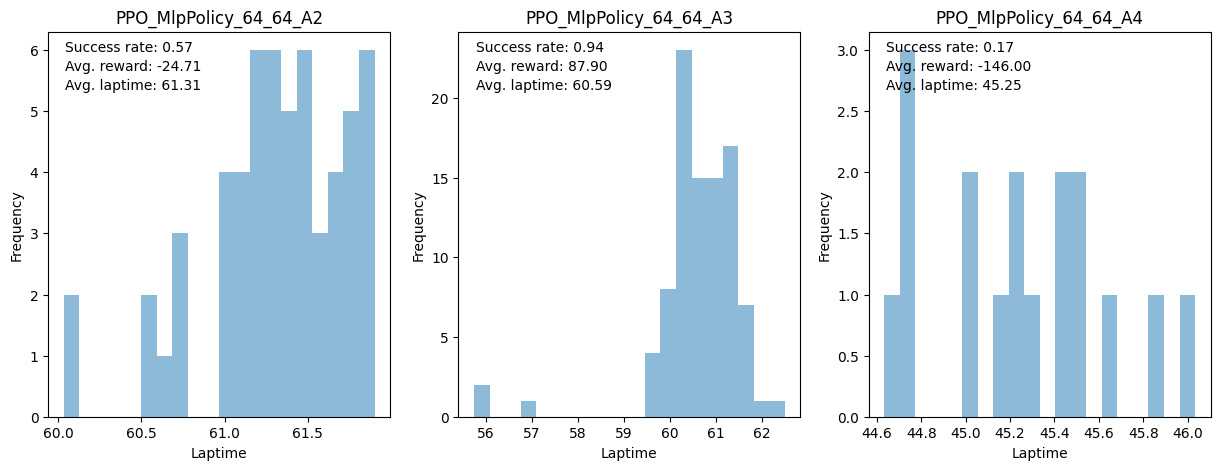

In [36]:
# Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (model_file, stats) in enumerate(model_stats.items()):
    success_rate = stats['successfull_episodes'] / stats['total_episodes']
    avg_reward = stats['total_reward'] / stats['total_episodes']
    avg_laptime = sum(stats['laptimes']) / len(stats['laptimes'])
    
    # histogram of lap times
    ax[i].hist(stats['laptimes'], bins=20, alpha=0.5, label=model_file)

    # Adding labels and titles
    ax[i].set_xlabel('Laptime')
    ax[i].set_ylabel('Frequency')
    ax[i].set_title(f"{model_file[23::].rstrip('.zip')}")

    # Adding stats
    ax[i].text(0.05, 0.95, f"Success rate: {success_rate:.2f}", transform=ax[i].transAxes)
    ax[i].text(0.05, 0.90, f"Avg. reward: {avg_reward:.2f}",
            transform=ax[i].transAxes)
    ax[i].text(0.05, 0.85, f"Avg. laptime: {avg_laptime:.2f}",
            transform=ax[i].transAxes)
    
plt.show()


![Racing](./resources/laptimes.png)

This evaluation runs revealed that the while the agent A4 is the fastest on the track, it only has a success rate of about 17%. The agent A3 is slower, but has the highest success rate of about 94% of the times finishing the track. The agent A2 is similarly fast as A3, but has a success rate of only about 57%.


### We can see the agent A3 in action

In [6]:
model_description = "PPO_MlpPolicy_64_64_A3"
env = MiniF1RLEnv()

# Load the latest checkpoint that matches the model description
checkpoint = latest_checkpoint_file_path(model_description)
model = PPO.load(checkpoint)

# Create and start the rendering thread
close_event = threading.Event()
render_thread = threading.Thread(target=render_loop, args=(env,close_event,False,30))
render_thread.start()

# Run the model
exit = False
while not exit:
    obs, info = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncate, info = env.step(action)
    
        if close_event.is_set():
            exit = True
            break

# Close the rendering thread and environment
close_event.set()
render_thread.join()
env.close()

![A3 Racing](./resources/RL_A3_Agent.gif)

Unfortunately, the agents from training runs V2 did not adapt well to the different track. Some of the agents from the training runs V1 had no problem adapting to the new track. Maybe after 1'000'000 timesteps the agents are overfitting to the track they were trained on.
![A3 Racing](./resources/RL_A3_Agent_SecondTrack.gif)


## How to proceed
There were quite some reinforcement learning tasks i initialy planed to do, but due to the time constraints i was not able to do them. I spent way more time on the environment and debugging than i planed. I would like to do the following tasks in the future:
- Try more algorithms with a wider range of hyperparameters and reward functions
- Implement the learning loop myself using PyTorch insted of the stable-baselines3 library
-  Using a hyperparameter optimization library to find the best hyperparameters for the environment. I started setting up Optuna, but i didn't have the time to finish it.